In [17]:
# For data handling
import pandas as pd
import numpy as np

# Disable warnings from printing
from warnings import filterwarnings
filterwarnings('ignore')

# For visualizations
import seaborn as sns
import matplotlib.pyplot as plt
% config InlineBackend.figure_format = 'png'
% matplotlib inline

# For data parsing
from datetime import datetime

# For choosing attributes that have good gaussian distribution
from scipy.stats import shapiro

# Needed for getting parameters for models
from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn import cluster
from sklearn.neighbors import KNeighborsClassifier

# For scaling/normalizing values
from sklearn.preprocessing import MinMaxScaler

In [18]:
def read_data(filename):
    dataset = pd.read_csv(filename, index_col=0)
    return dataset

# Read the dataset
train = read_data("../data/train.csv")
test = read_data("../data/test.csv")

# Calculate number of samples in training and test datasets
num_train = train.shape[0]
num_test = test.shape[0]

# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, "Open Date" : "P37"],
                  test.loc[:, "Open Date" : "P37"]), ignore_index=True)

In [19]:
# According to the paper
def parse_date(data):
    
    # Assume a date which is later than latest opening date of all the restaurants
    latest_date = datetime.strptime("01/01/2015", '%m/%d/%Y')
    
    open_num_days = []
    open_month = []
    open_year = []

    for date in data['Open Date']:
        cur_date = datetime.strptime(date, '%m/%d/%Y')
        open_num_days.append((latest_date - cur_date).days)
        open_month.append(cur_date.month)
        open_year.append(cur_date.year)

    data['Days'] = open_num_days
    # data['Month'] = open_month
    # data['Year'] = open_year
    
    # Log transform number of days since opened 
    data['Days'] = data['Days'].apply(np.log)
    # data['Month'] = data['Month'].apply(np.log)
    # data['Year'] = data['Year'].apply(np.log)
    
    del data["Open Date"]
    
    return data

# Parse date of opening of restaurant to get the number of days it has stayed open, month
# in which it opened and year in which it opened. The additional month and year features
# can potentially help proxy seasonality differences since restaurant revenues are
# highly cylical.
data = parse_date(data)

In [20]:
# Proposed treatment for City
# Replace city names with count of their frequency
city_counts = data["City"].value_counts()
data["City"] = data["City"].replace(city_counts)

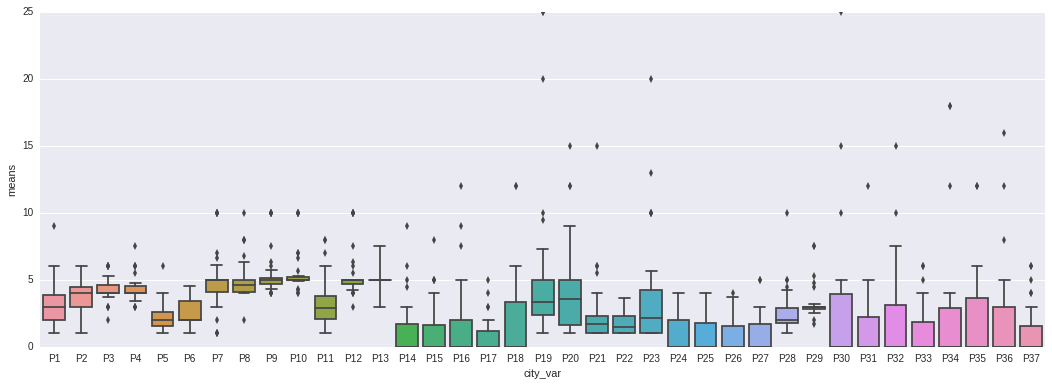

In [6]:
# According to the paper
# There is unaccounted problem for City as well.
# Plotting mean of P-variables over each city helps us see which P-variables are highly related to City
# since we are given that one class of P-variables is geographical attributes.
distinct_cities = train.loc[:, "City"].unique()

# Get the mean of each p-variable for each city
means = []
for col in train.columns[4:41]:
    temp = []
    for city in distinct_cities:
        temp.append(train.loc[train.City == city, col].mean())     
    means.append(temp)
    
# Construct data frame for plotting
city_pvars = pd.DataFrame(columns=["city_var", "means"])
for i in range(37):
    for j in range(len(distinct_cities)):
        city_pvars.loc[i+37*j] = ["P"+str(i+1), means[i][j]]
        
# Plot boxplot
plt.rcParams['figure.figsize'] = (18.0, 6.0)
sns.boxplot(x="city_var", y="means", data=city_pvars)

# From this we observe that P1, P2, P11, P19, P20, P23, and P30 are approximately a good
# proxy for geographical location.

In [144]:
# K Means treatment for city (mentioned in the paper)
def adjust_cities(data, train, k):
    
    # As found by box plot of each city's mean over each p-var
    relevant_pvars =  ["P1", "P2", "P11", "P19", "P20", "P23", "P30"]
    train = train.loc[:, relevant_pvars]
    
    # Optimal k is 20 as found by DB-Index plot    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(train)
    
    # Get the cluster centers and classify city of each data instance to one of the centers
    data['City Cluster'] = kmeans.predict(data.loc[:, relevant_pvars])
    del data["City"]
    
    return data

# Convert unknown cities in test data to clusters based on known cities using KMeans
data = adjust_cities(data, train, 20)

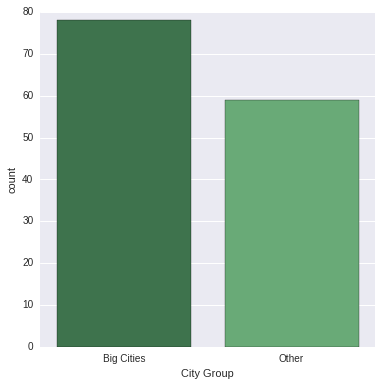

In [21]:
# According to the paper
# The two categories of City Group both appear very frequently
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.countplot(x='City Group', data=train, palette="Greens_d")

# One hot encode City Group
data = data.join(pd.get_dummies(data['City Group'], prefix="CG"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns.
data = data.drop(["City Group", "CG_Other"], axis=1)

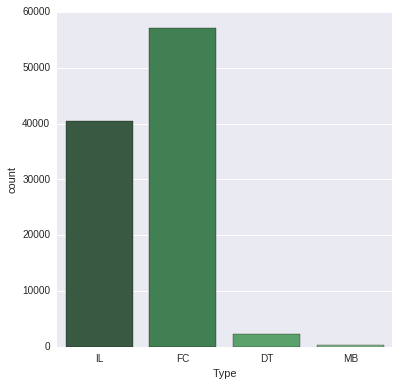

In [105]:
# Proposed alternative for Type treatment
# Two of the four Restaurant Types (DT and MB), are extremely rare
sns.countplot(x='Type', data=data, palette="Greens_d")

# One hot encode Restaurant Type
data = data.join(pd.get_dummies(data['Type'], prefix="T"))
 
# Drop the original column. Also drop the extremely rare restaurant types.
data = data.drop(["Type", "T_MB", "T_DT"], axis=1)

# Map values for the very rare restaurant types to one of the common types

# tofit are the rows in the train set that belong to one of the common restaurnat types
tofit = data[data.index<num_train]
tofit = tofit.ix[((tofit.T_FC == 1) | (tofit.T_IL == 1))]

# tofill are rows in either train or test that belong to one of the rare types
tofill = data.ix[((data.T_FC == 0) & (data.T_IL == 0))]

# Resaruants with type FC are labeled 1, those with type IL are labeled 0.
y = tofit.T_FC

# Drop the label columns
X = tofit.drop(["T_FC", "T_IL"], axis=1)

# Define and train a model to impute restaurant type
# The grid below just has a range of values that commonly
# work well with random forest type models (of which ExtraTrees is one).
model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16],
              'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]
             }
type_model = ExtraTreesClassifier(n_estimators=25, random_state=0)

grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)

type_model.set_params(**grid.best_params_)
type_model.fit(X, y)

imputations = type_model.predict(tofill.drop(["T_FC", "T_IL"], axis=1))
data.loc[(data.T_FC == 0) & (data.T_IL == 0), "T_FC"] = imputations
data = data.drop(["T_IL"], axis=1)

In [22]:
# According to the paper
def adjust_type(data):
    
    # Augment data with id for original order of records
    data.loc[:, "tempIdx"] = data.index
    
    # Get records with restaurant type = "Mobile"
    query_matrix = data.loc[data.Type == "MB", :]
    
    # Get records with restaurant type != "Mobile"
    search_matrix = data.loc[data.Type != "MB", :]

    # Use only continuous features for classification
    features = data.columns.values[2:]

    # Predict known type using KNN
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(search_matrix.loc[:, features], search_matrix.loc[:, 'Type'])
    query_matrix.loc[:, 'Type'] = clf.predict(query_matrix.loc[:, features])
    
    # Construct data to original form and order
    data = pd.concat((search_matrix.loc[:, "Type" : "tempIdx"],
                      query_matrix.loc[:, "Type" : "tempIdx"]), ignore_index = True)
    data = data.sort_values(["tempIdx"])
    del data["tempIdx"]
    
    # One hot encode Type
    data = data.join(pd.get_dummies(data['Type'], prefix="T"))

    # Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
    # And drop the original columns.
    data = data.drop(["Type", "T_IL"], axis=1)
    
    return data

# Convert unknown restaurant types in test data to known restaurant types using KNN
data = adjust_type(data)

In [23]:
# Proposed idea, in addition to the paper
# A certain set of columns are either mostly all zero or all non-zero.  
# We added a feature to mark this  - The "zeros" feature that holds this count of zero columns.

# The features with the notable zero behavior:
zero_cols = ['P14', 'P15', 'P16', 'P17', 'P18', 'P24', 'P25', 'P26', 'P27', 'P30', 'P31', 'P32', 'P33',
             'P34', 'P35', 'P36', 'P37']

data['zeros'] = (data[zero_cols] == 0).sum(1)

In [24]:
# Proposed alternative to categorical vs continuous problem
# one hot encoding for "P" variables - taking them as categorical
for col in data.columns:
    if col[0] == 'P':
        data = data.join(pd.get_dummies(data[col], prefix=col))
        # Since only n-1 columns are needed to binarize n categories,
        # drop one of the new columns.
        data = data.drop([col, data.columns[-1]], axis=1)

In [25]:
# Proposed idea, in addition to the paper
# Scale all input features to between 0 and 1.
min_max_scaler = MinMaxScaler()

data = pd.DataFrame(data=min_max_scaler.fit_transform(data),
                    columns=data.columns, index=data.index)

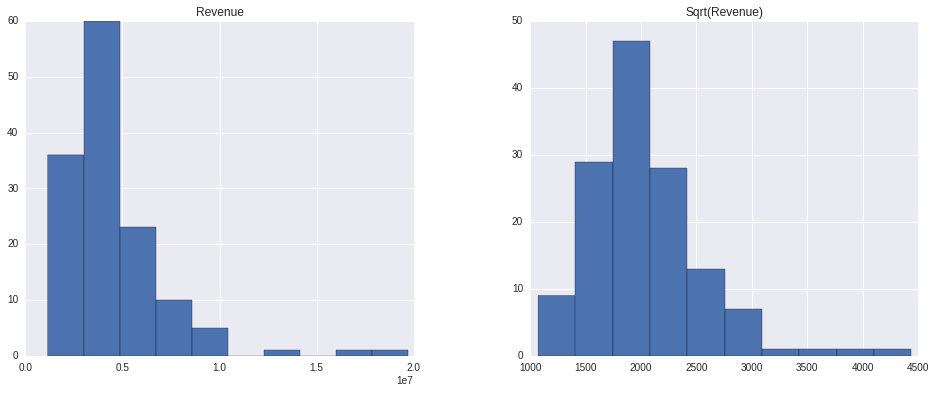

In [26]:
# Sqrt  treatment before after distributions
plt.rcParams['figure.figsize'] = (16.0, 6.0)
graph_data = pd.DataFrame(
        {
            ("Revenue") : train["Revenue"],
            ("Sqrt(Revenue)") : np.sqrt(train["Revenue"])
        }
    )
graph_data.hist()

# Proposed sqrt treatment for revenue
# Scale revenue by sqrt. 
# The purpose is to decrease the influence of the few very large revenue values.
train["Revenue"] = train.Revenue.apply(np.sqrt)

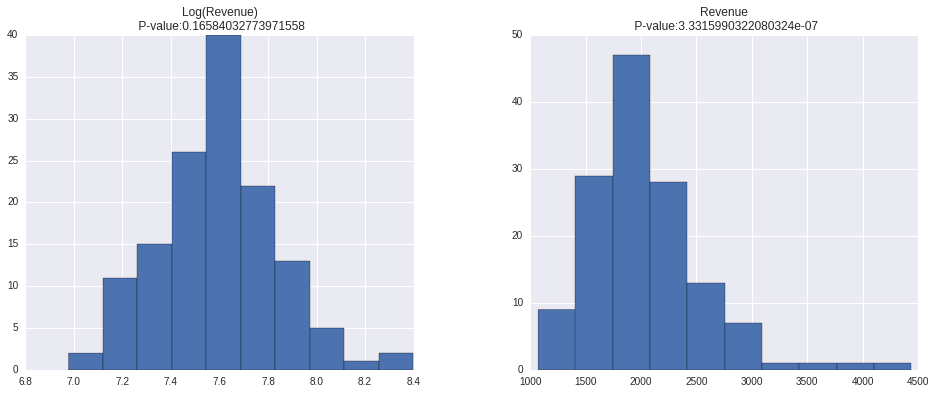

In [346]:
# According to the paper
# Check distribution of revenue and log(revenue)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train["Revenue"])[1]
pvalue_after = shapiro(np.log(train["Revenue"]))[1]
graph_data = pd.DataFrame(
        {
            ("Revenue\n P-value:" + str(pvalue_before)) : train["Revenue"],
            ("Log(Revenue)\n P-value:" + str(pvalue_after)) : np.log(train["Revenue"])
        }
    )
graph_data.hist()

# log transform revenue as it is approximately normal. If this distribution for revenue holds in the test set,
# log transforming the variable before training models will improve performance vastly.
# However, we cannot be completely certain that this distribution will hold in the test set.
train["Revenue"] = np.log(train["Revenue"])

In [27]:
# Split into train and test datasets
train_processed = data[:num_train]
test_processed = data[num_train:]

In [454]:
# SVR model
svr_clf = SVR()
svr_clf.fit(train_processed, train["Revenue"])
results_svm = svr_clf.predict(test_processed)

In [ ]:
# Log treatment
results_svm = np.exp(results_svm)

In [455]:
# Sqrt treatment
results_svm = np.square(results_svm)

In [456]:
# RF model
rf = RandomForestRegressor()
rf.fit(train_processed, train["Revenue"])
results_rf = rf.predict(test_processed)

In [75]:
# Log treatment
results_rf = np.exp(results_rf)

In [457]:
# Sqrt treatment
results_rf = np.square(results_rf)

In [28]:
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model_grid

[{'alpha': array([  1.00000000e+00,   1.59985872e+00,   2.55954792e+00,
           4.09491506e+00,   6.55128557e+00,   1.04811313e+01,
           1.67683294e+01,   2.68269580e+01,   4.29193426e+01,
           6.86648845e+01,   1.09854114e+02,   1.75751062e+02,
           2.81176870e+02,   4.49843267e+02,   7.19685673e+02,
           1.15139540e+03,   1.84206997e+03,   2.94705170e+03,
           4.71486636e+03,   7.54312006e+03,   1.20679264e+04,
           1.93069773e+04,   3.08884360e+04,   4.94171336e+04,
           7.90604321e+04,   1.26485522e+05,   2.02358965e+05,
           3.23745754e+05,   5.17947468e+05,   8.28642773e+05,
           1.32571137e+06,   2.12095089e+06,   3.39322177e+06,
           5.42867544e+06,   8.68511374e+06,   1.38949549e+07,
           2.22299648e+07,   3.55648031e+07,   5.68986603e+07,
           9.10298178e+07,   1.45634848e+08,   2.32995181e+08,
           3.72759372e+08,   5.96362332e+08,   9.54095476e+08,
           1.52641797e+09,   2.44205309e+09,  

In [29]:
ridge_clf = Ridge()
grid = GridSearchCV(ridge_clf, model_grid, cv=LeaveOneOut(train.shape[0]), scoring='mean_squared_error')
grid

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=137),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e+00,   1.59986e+00,   2.55955e+00,   4.09492e+00,
         6.55129e+00,   1.04811e+01,   1.67683e+01,   2.68270e+01,
         4.29193e+01,   6.86649e+01,   1.09854e+02,   1.75751e+02,
         2.81177e+02,   4.49843e+02,   7.19686e+02,   1.15140e+03,
         1...9,   2.44205e+09,   3.90694e+09,
         6.25055e+09,   1.00000e+10]), 'normalize': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [30]:
grid.fit(train_processed, train["Revenue"])
grid.best_params_

{'alpha': 4.0949150623804256, 'normalize': True}

In [458]:
# Proposed idea
# Ridge model
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
ridge_clf = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
grid = GridSearchCV(ridge_clf, model_grid, cv=LeaveOneOut(train.shape[0]), scoring='mean_squared_error')
grid.fit(train_processed, train["Revenue"])

# Re-train on full training set using the best parameters found in the last step.
ridge_clf.set_params(**grid.best_params_)
ridge_clf.fit(train_processed, train["Revenue"])

# results_ridge = np.exp(ridge_clf.predict(test_processed))
results_ridge = ridge_clf.predict(test_processed)

In [459]:
# Proposed idea
# Lasso model
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
lasso_clf = Lasso()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
grid = GridSearchCV(lasso_clf, model_grid, cv=LeaveOneOut(train.shape[0]), scoring='mean_squared_error')
grid.fit(train_processed, train["Revenue"])

# Re-train on full training set using the best parameters found in the last step.
lasso_clf.set_params(**grid.best_params_)
lasso_clf.fit(train_processed, train["Revenue"])

results_lasso = lasso_clf.predict(test_processed)

In [112]:
# Log treatment
results_ridge = np.exp(results_ridge)

In [460]:
# Sqrt treatment
results_ridge = np.square(results_ridge)

In [461]:
# Sqrt treatment
results_lasso = np.square(results_lasso)

In [331]:
# Try out different ensembles
# Ensembling helps to average out the error due to different models
# Paper
results_agg = 0.5*results_rf + 0.5*results_svm

In [386]:
# More weight to SVR as it gave the best individual results
results_agg = 0.3*results_rf + 0.2*results_svm + 0.5*results_ridge

In [462]:
# More weight to SVR as it gave the best individual results
results_agg = 0.3*results_ridge + 0.3*results_lasso + 0.25*results_rf + 0.15*results_svm

In [402]:
# Final results
results_final = results_ridge

In [246]:
# Final results
results_final = results_rf

In [312]:
results_final = results_svm

In [463]:
results_final = results_agg

In [419]:
results_final = results_lasso

In [464]:
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=results_final)
submission.index.name = 'Id'

In [465]:
submission.describe().astype(int)

,Prediction
count,100000
mean,4295193
std,646709
min,2346455
25%,3851618
50%,4261072
75%,4690289
max,7732133


In [466]:
# Write out the submission
submission.to_csv("../temp.csv")